In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import dirichlet

from matplotlib import rcParams

rcParams['figure.dpi'] = 300

In [6]:
# lil helper to grab config by spike value
def get_spike_config(configs, spike_val):
    return next(c for c in configs 
                if 'spike' in c['name'] and c['config']['dataset']['spike'] == spike_val)

# load + prep dataset
def prepare_dataset(dataset_cfg, num_probs):
    probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    dataset.probs = probs
    dataset.data = dataset.sample(probs, dataset.n_per_multinomial, 
                                  probs.shape[0], dataset.data.shape[1]*10, [probs.shape[1]])
    return dataset

# load encoder and move to device
def load_encoder(cfg, path, device):
    enc = hydra.utils.instantiate(cfg)
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    enc.eval()
    enc.to(device)
    return enc

# core logic!
def run_distance_eval(spike_vals, num_probs=1000, base_dir='outputs/'):
    configs = get_all_experiments_info(base_dir, False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print('loading configs and models...')
    encoders = {}
    for spike in spike_vals:
        cfg = get_spike_config(configs, spike)
        encoders[spike] = load_encoder(cfg['config']['encoder'], cfg['dir'], device)
    print('models ready!')

    dataset_cfg = get_spike_config(configs, spike_vals[0])['config']['dataset']
    dataset = prepare_dataset(dataset_cfg, num_probs)
    print('dataset ready :)')

    with torch.no_grad():
        fr = torch.tensor(dataset.fisher_rao_distance(dataset.probs[:num_probs]))
        x = torch.tensor(dataset.data[:num_probs], dtype=torch.float32).to(device)

        l2_dists = {}
        for spike, encoder in encoders.items():
            z = encoder(x)
            l2_dists[spike] = torch.cdist(z, z, p=2)

    a, b = np.meshgrid(dataset.probs[:num_probs, 0], dataset.probs[:num_probs, 0])
    pairs = np.stack([a.ravel(), b.ravel()], axis=1)

    data = {
        "P1": pairs[:, 0],
        "P2": pairs[:, 1],
        "FR": fr.cpu().ravel()
    }

    for spike, dist in l2_dists.items():
        data[spike] = dist.cpu().ravel()

    return pd.DataFrame(data)

# example usage:
# df = run_distance_eval([1, 5, 10], 1000)


In [7]:
n_points = 1000

spike_vals = [0.01, 0.1, 1, 10, 100]
df = run_distance_eval(spike_vals, n_points)
cols = df.columns.difference(['P1', 'P2'])
df[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())

loading configs and models...
models ready!
dataset ready :)


In [8]:
df.head()

,P1,P2,FR,0.01,0.1,1,10,100
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001001,0.0,0.020145,0.063399,0.030082,0.004208,0.003399,0.006621
2,0.002002,0.0,0.028494,0.134309,0.079219,0.028573,0.010970,0.021977
3,0.003003,0.0,0.034904,0.130512,0.075476,0.022251,0.009073,0.018925
4,0.004004,0.0,0.040310,0.143965,0.091150,0.038275,0.015700,0.026188


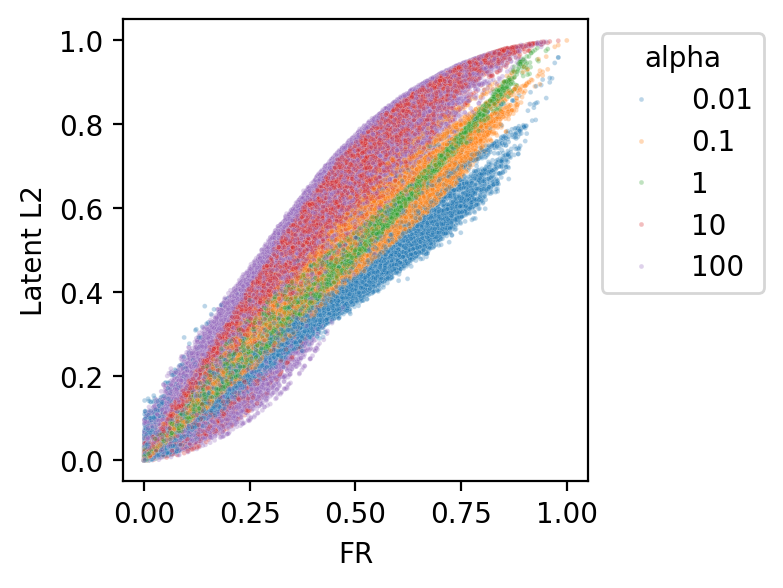

In [9]:
df_long = df.melt(id_vars=["P1", "P2", "FR"], 
                      value_vars=spike_vals,
                      var_name="alpha", value_name="Latent L2")

# extract spike value from column name (e.g., "S1_L2" → 1)
df_long = df_long.sample(frac=0.1)

# plot!

fig, ax = plt.subplots(figsize=(3,3), dpi=200)
g = sns.scatterplot(data=df_long, x="FR", y="Latent L2", 
                    hue="alpha", palette="tab10", 
                s=3, 
                alpha=0.3, ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()


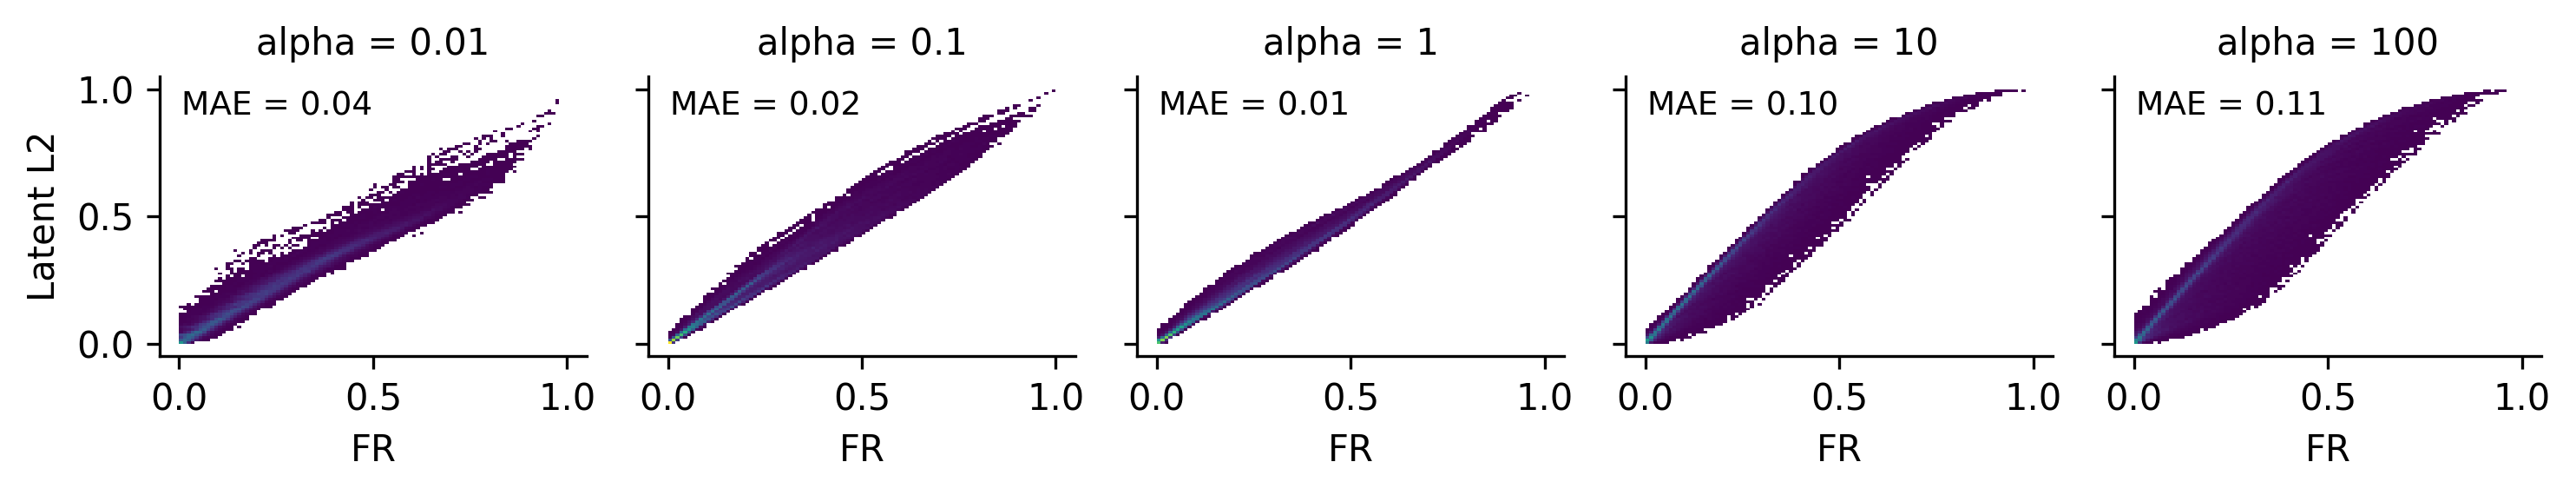

In [10]:
g = sns.displot(
    df_long, x='FR', y='Latent L2',
    col='alpha', kind='hist',
    cmap='viridis', bins=100,
    facet_kws=dict(margin_titles=True),
    height=2, aspect=1,
)

# annotate each subplot with Pearson r :)
for val, ax in zip(g.col_names, g.axes.flat):
    sub = df_long[df_long['alpha'] == val]
    mae = np.mean(np.abs(np.nan_to_num(sub['FR'].values) - 
                    np.nan_to_num(sub['Latent L2'].values)))
    ax.text(0.05, 0.95, f"MAE = {mae:.2f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9, color='black')

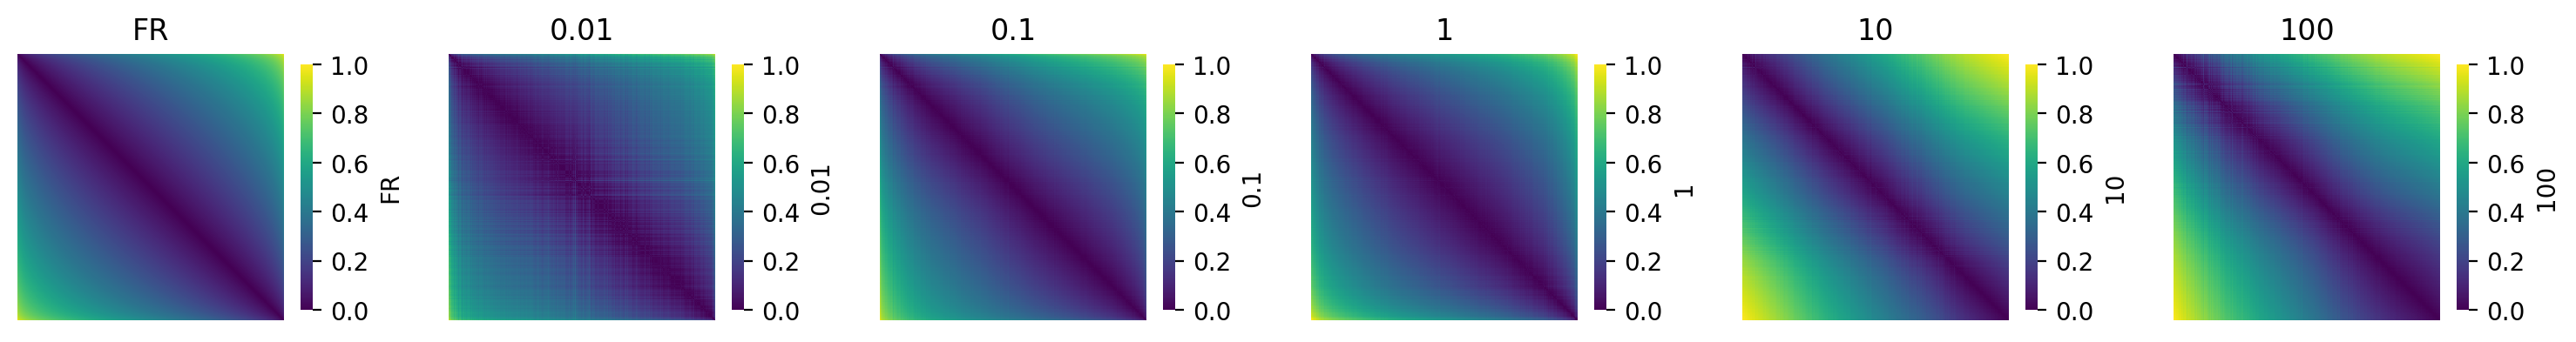

In [15]:
heatmaps = [("FR", df["FR"])] + [(col, df[col]) for col in spike_vals]

fig, axs = plt.subplots(1, len(heatmaps), figsize=(15, 5), dpi=200)

for i, (name, vals) in enumerate(heatmaps):
    grid = vals.values.reshape((n_points, n_points))

    sns.heatmap(grid, cmap='viridis', square=True, cbar_kws={"label": name, 'shrink':0.3},
    ax = axs[i])
    axs[i].set_title(f"{name}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()

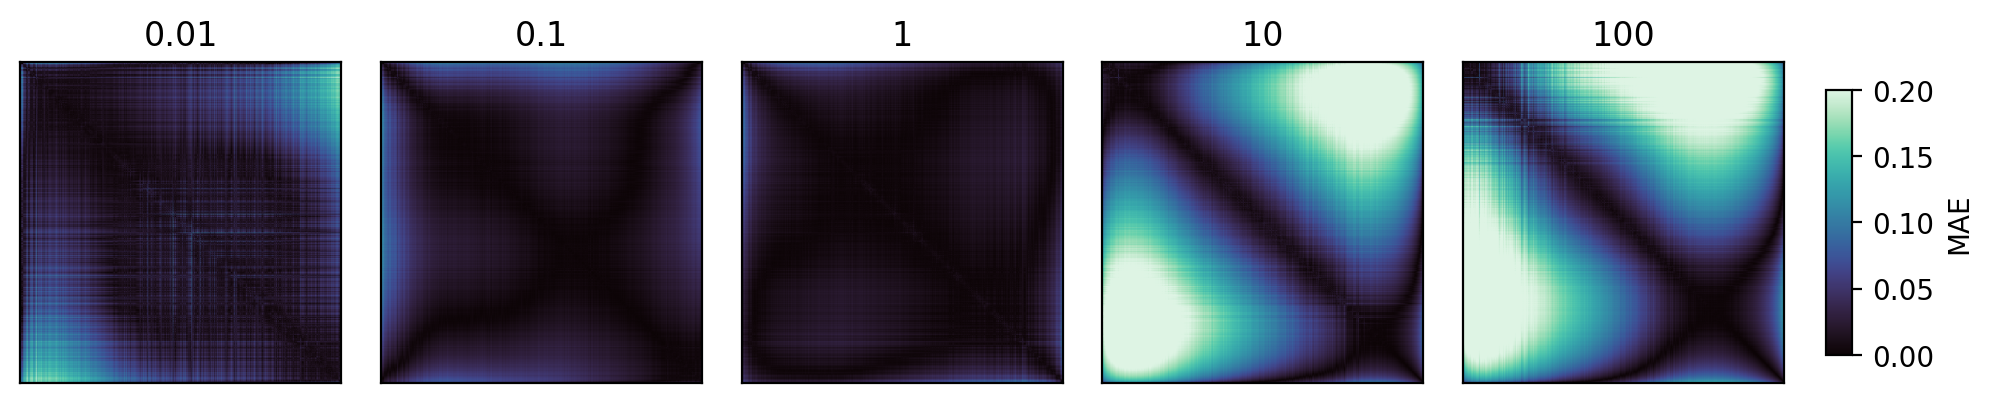

In [16]:
def to_grid(x): return x.values.reshape(n_points, n_points)
def normalize(x): return (x - x.min()) / (x.max() - x.min())

# normalize FR grid
fr_grid = to_grid(normalize(df["FR"]))

# find relevant L2 columns
l2_cols = spike_vals
n = len(l2_cols)

fig, axes = plt.subplots(1, n+1, figsize=(2*n, 2), width_ratios=[1]*n + [0.1], dpi=200)
vmin, vmax = 0, 0.2  # shared color scale
all_dists = []

# compute all distortions first
for col in l2_cols:
    l2_grid = to_grid(normalize(df[col]))
    dist = np.abs(l2_grid - fr_grid)
    all_dists.append(dist)

# plot heatmaps
for ax, col, dist in zip(axes, l2_cols, all_dists):
    im = ax.imshow(dist, cmap="mako", vmin=vmin, vmax=vmax)
    ax.set_title(col)
    ax.set_xticks([])
    ax.set_yticks([])

# shared colorbar
cbar = fig.colorbar(im, ax=axes[-1], aspect=10, fraction=0.8)
cbar.set_label("MAE")
axes[-1].set_axis_off()
plt.tight_layout()
plt.show()

In [17]:
# plt.figure(figsize=(8, 3))

# for i in range(7):
#     plt.plot([0, 1], [i, i], color='black', lw=1, ls='-', zorder=0)

# for r, D in enumerate([fr_grid] + [to_grid(df[col]) 
#                                    for col in l2_cols]):
    
#     n = D.shape[0]
#     x = np.zeros(n)
#     for i in range(1, n):
#         x[i] = x[i-1] + D[i-1, i]

#     x /= x.max()

#     # plot the line!
#     plt.scatter(x, r+np.ones_like(x), color=sns.color_palette('tab10'), s=100)

# plt.scatter(df['P1'][:n_points], 
#             np.zeros_like(x), color=sns.color_palette('tab10'), s=100)

# plt.ylim(-0.5, 6.5)
# plt.yticks(range(7), [r'$p_0$', 'FR'] + l2_cols)
# plt.show()